In [1]:
import os
import glob
import numpy as np
import sklearn
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_raster
from skimage.exposure import rescale_intensity
import pickle
from functools import partial

from matplotlib import pyplot as plt
import time
from tqdm.notebook import tqdm

# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
from dask.distributed import Client, progress

In [2]:
from src.data.load import load_features
from src.visualization.utils import colorize_dynamic_world

In [3]:
# create a hub to control the workers
c = Client()

/home/ddiaz/mambaforge/envs/forest_mapping/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38853 instead
  warnings.warn(


In [4]:
YEAR = 2022
STATE = "washington"

In [5]:
TILES = f"../data/interim/{STATE}_quarter_quads.shp"
tiles = gpd.read_file(TILES)
tiles.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    5772 non-null   int64   
 1   CELL_ID     5772 non-null   int64   
 2   CELL_NAME   5772 non-null   object  
 3   PRIMARY_ST  5772 non-null   object  
 4   CELL_MAPCO  5772 non-null   object  
 5   CELL_TYPE   5772 non-null   int64   
 6   CELL_ALLWA  5772 non-null   int64   
 7   CELL_DESCR  4 non-null      object  
 8   CELL_DIACR  0 non-null      object  
 9   GLOBALID    5772 non-null   object  
 10  SHAPE_Leng  5772 non-null   float64 
 11  SHAPE_Area  5772 non-null   float64 
 12  geometry    5772 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 586.3+ KB


In [6]:
MODEL = "../models/structure_models/production/global-sentinel-HistGradientBoostingRegressor-multioutput.pkl"
model = pickle.load(open(MODEL, "rb"))

In [7]:
BAND_DESCRIPTIONS = {
    1: "Canopy Cover",
    2: "Dominant Height",
    3: "Live Tree Basal Area",
    4: "Quadratic Mean Diameter",
    5: "Trees Per Acre (Growing Stock)",
    6: "Aboveground Live Tree Biomass",
    7: "Dynamic World Land Cover",
}
BAND_UNITS = {
    1: "Percent",
    2: "Feet",
    3: "Square feet per acre",
    4: "Inches",
    5: "Trees Per Acre",
    6: "",
    7: "",
}

In [8]:
def load_predict(cell_id, year, state, overwrite=False):
    dwfile = f"../data/interim/{state}_imagery/dynamic_world/{cell_id}_dynamicworld{year}.tif"
    X = load_features(f"../data/interim/{state}_imagery", cell_id, year)

    with rasterio.open(
        f"../data/interim/{state}_imagery/sentinel/{cell_id}_sentinel{year}.tif"
    ) as src:
        profile = src.profile
        height, width = profile["height"], profile["width"]
    # check for nodata in input dataframe
    pred = model.predict(X)
    for i in range(pred.shape[1]):
        if i == 0:
            pred[:, i] = np.clip(pred[:, i], 0, 100)  # clip canopy cover to 0-100
        else:
            pred[:, i] = np.clip(pred[:, i], 0, None)  # clip negative structure values
    pred = pred.reshape((height, width, 6))

    with rasterio.open(dwfile) as dw_src:
        dw = dw_src.read(1)

    profile.update(nodata=-9999, count=7, dtype="int16")

    pred[:][~np.isin(dw, [1, 5])] = profile["nodata"]

    pred_ras = reshape_as_raster(pred).astype("int16")
    # for i, band in enumerate(pred_ras):
    #     # max_val = 100 if i == 0 else None
    #     # pred_ras[i] = np.clip(band, 0, None)

    return np.vstack((pred_ras, dw.reshape(1, height, width))), profile

In [9]:
def load_predict_save(cell_id, year, state, overwrite=False):
    outfile = f"../data/processed/{state}/predictions/{cell_id}_structure{year}.tif"
    if not os.path.exists(outfile) or overwrite:
        try:
            pred_ras, profile = load_predict(cell_id, year, state)

            with rasterio.open(outfile, "w", **profile) as dst:
                for i in range(profile["count"]):
                    dst.write(pred_ras[i], i + 1)
                    dst.set_band_description(i + 1, BAND_DESCRIPTIONS[i + 1])
                    dst.set_band_unit(i + 1, BAND_UNITS[i + 1])

        except Exception as e:
            print("Failed on", cell_id, e)
    return cell_id

In [10]:
to_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif")
]

In [11]:
os.makedirs(f"../data/processed/{STATE}/predictions/", exist_ok=True)

In [12]:
CELL_ID = np.random.choice(to_run)

with rasterio.open(
    f"../data/interim/{STATE}_imagery/sentinel/{CELL_ID}_sentinel{YEAR}.tif"
) as src:
    height, width = src.height, src.width
    img = src.read()
    profile = src.profile

pred, prof = load_predict(CELL_ID, YEAR, STATE)
pred = np.ma.masked_values(pred, -9999)

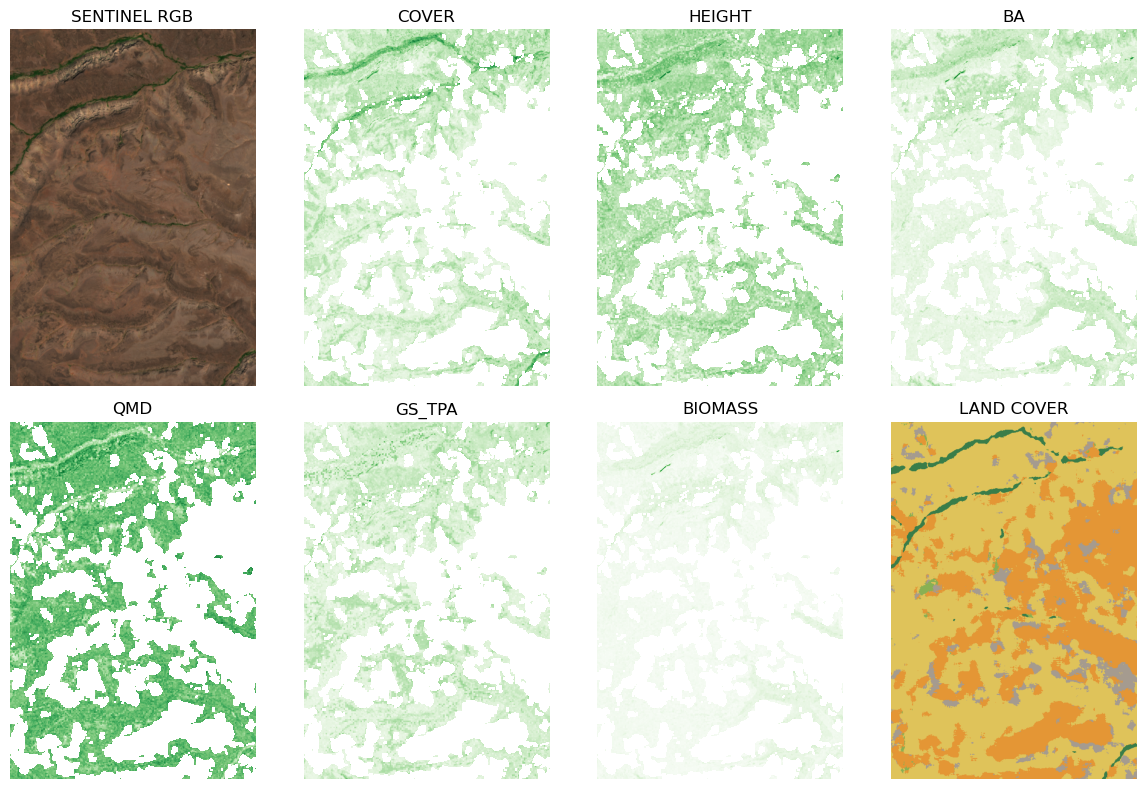

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(12, 8))
axs.ravel()[0].imshow(
    rescale_intensity(
        np.dstack((img[2], img[1], img[0])), in_range=(0, 3000), out_range="uint8"
    ).astype("uint8")
)
TITLES = [
    "SENTINEL RGB",
    "COVER",
    "HEIGHT",
    "BA",
    "QMD",
    "GS_TPA",
    "BIOMASS",
    "LAND COVER",
]
for i in range(8):
    axs.ravel()[i].set_title(TITLES[i])
    axs.ravel()[i].axis("off")
    if i == 7:
        axs.ravel()[i].imshow(colorize_dynamic_world(pred[i - 1]))
    elif i > 0:
        axs.ravel()[i].imshow(pred[i - 1] / pred[i - 1].max(), cmap="Greens")

plt.tight_layout()
plt.show()

In [14]:
pred.max(axis=(1, 2)).data, pred.mean(axis=(1, 2)).data, pred.min(axis=(1, 2)).data

(array([ 76, 103, 170,  19, 216,  83,   7], dtype=int16),
 array([21.65347048, 46.57821297, 25.6329228 , 11.29482844, 41.94163703,
         4.55434646,  4.72742581]),
 array([ 6, 20,  0,  3,  0,  0,  0], dtype=int16))

In [15]:
can_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/interim/{STATE}_imagery/sentinel/*{YEAR}.tif")
]
already_run = [
    os.path.basename(f).split("_")[0]
    for f in glob.glob(f"../data/processed/{STATE}/predictions/*")
]
to_run = [x for x in can_run if x not in already_run]

In [16]:
# load_predict_save(314753, year=2022, state='washington')

In [17]:
# to_run = np.unique(tiles.CELL_ID.values)

In [18]:
# with tqdm(total=len(to_run)) as pbar:
#     completed = []
#     with ThreadPoolExecutor(4) as executor: # 12 mins for 130 predictions
#         # with parallel_backend('loky', n_jobs=1):
#         jobs = [executor.submit(load_predict_save, cell_id, YEAR, STATE) for cell_id in to_run]
#         for job in as_completed(jobs):
#             completed.append(job.result())
#             pbar.update()

In [19]:
# start batch
run_model = partial(load_predict_save, year=YEAR, state=STATE)

In [20]:
res = c.map(run_model, to_run)
print("Started batch processing.")

Started batch processing.


In [21]:
with tqdm(total=len(can_run), smoothing=0.7) as pbar:
    finished = len(glob.glob(f"../data/processed/{STATE}/predictions/*.tif"))
    pbar.update(finished)
    while finished < len(can_run):
        now = len(glob.glob(f"../data/processed/{STATE}/predictions/*.tif"))
        pbar.update(now - finished)
        finished = now
        time.sleep(0.1)

  0%|          | 0/5772 [00:00<?, ?it/s]

In [22]:
# c.close()

In [23]:
# c.cancel(res)